existing iceberg namespaces: $[('enox',)]
existing iceberg tables: $[('enox', 'smartMeter_incoming')]
iceberg table schema: $table {
  1: owner: required struct<2: id: required string>
  3: current: required struct<4: L1: required struct<5: centiAmpere: required long>, 6: L2: required struct<7: centiAmpere: required long>, 8: L3: required struct<9: centiAmpere: required long>>
  10: readingFrom: required string
  11: meter: required struct<12: meterId: required struct<13: value: required string>, 14: systemTitle: required struct<15: data: required string>>
  16: id: required struct<17: id: required string>
  18: power: required struct<19: feed: required struct<20: watt: required long>, 21: draw: required struct<22: watt: required long>>
  23: receivedAt: required string
  24: device: required struct<25: deviceId: required struct<26: value: required string>>
  27: energy: required struct<28: consumption: required struct<29: wattHours: required long>, 30: feedIn: required struct<31: watt

None

,owner,device,energy
0,{'id': '59c3d063-d6d8'},{'deviceId': {'value': 'ECUC012A3101E0.cuculus...,"{'consumption': {'wattHours': 418}, 'feedIn': ..."
1,{'id': '62c3d063-d6d3'},{'deviceId': {'value': 'ECUC012A3101H3.cuculus...,"{'consumption': {'wattHours': 2847}, 'feedIn':..."
2,{'id': '62c3d063-d6d3'},{'deviceId': {'value': 'ECUC012A3101H3.cuculus...,"{'consumption': {'wattHours': 7999}, 'feedIn':..."
3,{'id': '62c3d063-d6d3'},{'deviceId': {'value': 'ECUC012A3101H3.cuculus...,"{'consumption': {'wattHours': 5586}, 'feedIn':..."
4,{'id': '62c3d063-d6d3'},{'deviceId': {'value': 'ECUC012A3101H3.cuculus...,"{'consumption': {'wattHours': 3375}, 'feedIn':..."
...,...,...,...
408,{'id': '65c3d063-d6d6'},{'deviceId': {'value': 'ECUC012A3101K6.cuculus...,"{'consumption': {'wattHours': 7016}, 'feedIn':..."
409,{'id': '59c3d063-d6d8'},{'deviceId': {'value': 'ECUC012A3101E0.cuculus...,"{'consumption': {'wattHours': 3378}, 'feedIn':..."
410,{'id': '62c3d063-d6d3'},{'deviceId': {'value': 'ECUC012A3101H3.cuculus...,"{'consumption': {'wattHours': 1950}, 'feedIn':..."
411,{'id': '62c3d063-d6d3'},{'deviceId': {'value': 'ECUC012A3101H3.cuculus...,"{'consumption': {'wattHours': 7613}, 'feedIn':..."


array([[<Axes: title={'center': 'consumption'}>]], dtype=object)

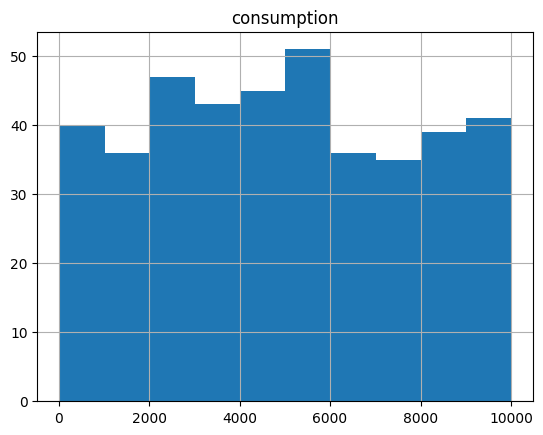

In [7]:

import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import duckdb
import os
from pyiceberg.catalog import load_catalog
from pyiceberg.partitioning import PartitionSpec, PartitionField
from pyiceberg.transforms import DayTransform, BucketTransform
from pyiceberg.schema import Schema
from pyiceberg.types import (
    TimestampType,
    FloatType,
    DoubleType,
    StringType,
    NestedField,
    StructType,
)
from pyiceberg.expressions import GreaterThanOrEqual, LessThan

catalog_name = 'default'
iceberg_namespace = 'enox'
table_name = 'enox.smartMeter_incoming'

schema = Schema(
    NestedField(field_id=1, name="datetime", field_type=TimestampType(), required=True),
    NestedField(field_id=2, name="symbol", field_type=StringType(), required=True),
    NestedField(field_id=3, name="bid", field_type=FloatType(), required=False),
    NestedField(field_id=4, name="ask", field_type=DoubleType(), required=False),
    NestedField(
        field_id=5,
        name="details",
        field_type=StructType(
            NestedField(
                field_id=4, name="created_by", field_type=StringType(), required=False
            ),
        ),
        required=False,
    ),
)

#ps = duckdb.sql("SELECT * FROM parquet_schema('smartMeter-incoming+1+0000000000.snappy.parquet')")
#display(ps)
#arr = duckdb.read_parquet('smartMeter-incoming+1+0000000000.snappy.parquet').arrow()
parquet_df = pq.read_table('smartMeter-incoming+1+0000000000.snappy.parquet')
#display(parquet_df)
iceberg_catalog = load_catalog(catalog_name)
nss = iceberg_catalog.list_namespaces()
print(f"existing iceberg namespaces: ${nss}")
if(len(nss) == 0):
    iceberg_catalog.create_namespace("enox")

partition_spec1 = PartitionSpec(
    PartitionField(source_id=10, field_id=1000, transform=DayTransform(), name="readingFrom_day")
)

if not(iceberg_catalog.table_exists(table_name)):
   iceberg_catalog.create_table(
        table_name,
        schema = parquet_df.schema,
    )
print(f"existing iceberg tables: ${iceberg_catalog.list_tables(iceberg_namespace)}")
iceberg_table = iceberg_catalog.load_table(table_name)

print(f"iceberg table schema: ${iceberg_table.schema()}")
print(f"iceberg table metadata: ${iceberg_table.metadata}")
print(f"iceberg table location: ${iceberg_table.location}")
print(f"iceberg table current snapshot: ${iceberg_table.current_snapshot()}")
print(f"iceberg table spec: ${iceberg_table.spec()}")

#with iceberg_table.update_spec() as update:
    #update.add_field('readingFrom', DayTransform(), 'readingFrom_day')

partition_spec = PartitionSpec(
    PartitionField(source_id=1, field_id=1000, transform=DayTransform(), name="datetime_day")
)

partition_spec1 = PartitionSpec(
    PartitionField(source_id=10, field_id=1000, transform=DayTransform(), name="readingFrom_day")
)

test_table = iceberg_catalog.create_table (
        identifier="enox.test",
        schema=schema,
        #partition_spec=partition_spec,
)

print(f"test table schema: ${test_table.schema()}")
print(f"test table metadata: ${test_table.metadata}")
print(f"test table location: ${test_table.location}")
#print(f"test table partitions: ${test_table.inspect.partitions()}")


#if(len(filter(lambda n: n[0] == iceberg_namespace, nss) ) == 0):
    
if(len(iceberg_table.scan().to_arrow()) == 0):
    iceberg_table.append(parquet_df)
else:
    iceberg_table.overwrite(parquet_df)
print(len(iceberg_table.scan().to_arrow()))

pdf = iceberg_table.scan(
    #row_filter = "readingFrom >= '2024-08-19T12:11:35Z' and readingFrom < '2024-08-19T13:37:55Z'",
    row_filter = GreaterThanOrEqual("readingFrom", '2024-08-19T12:11:35Z') and LessThan("readingFrom", '2024-08-19T13:37:55Z'),
    selected_fields = ("owner", "device", "energy")
).to_pandas()

display(pdf.info())

display(pdf)
vals = pdf.energy.apply(lambda x: x.get('consumption').get('wattHours')).values
vdf = pd.DataFrame(vals,columns=["consumption"])


vdf.hist(column='consumption')

#iceberg_catalog.drop_table('enox.test')
#iceberg_catalog.drop_table(table_name)
